In [1]:
import os

os.chdir("../..")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import tqdm.notebook as tqdm

from modular_splicing.motif_names import get_motif_names
from modular_splicing.models_for_testing.list import FM, AM

from modular_splicing.motif_perturbations.perturbations_on_standardized_sample import (
    all_mpi_on_standardized_sample,
)
from modular_splicing.motif_perturbations.summarize_effect import (
    positional_effects_near_splicepoints,
)
from modular_splicing.motif_perturbations.renderer import (
    plot_sensitivity_by_motif, EffectPlotter,
)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
num_motifs = 79
models = FM.binarized_models() + AM.binarized_models()

In [5]:
perturbations = all_mpi_on_standardized_sample(
    models, always_use_fm=False, is_binary=True, sl=1000, amount=64_000
)

In [6]:
full_data = {
    m.name: positional_effects_near_splicepoints(
        perturbations[m.name],
        num_motifs=num_motifs,
        blur_radius=20,
        effect_radius=200,
        normalize_mode="by_motifs_presence",
    )
    for m in models
}

In [7]:
names = get_motif_names("rbns")

In [8]:
to_json = {k : full_data[k].tolist() for k in full_data}

In [9]:
with open("output-csvs/binarized/downstream-effects.json", "w") as f:
    json.dump(to_json, f)

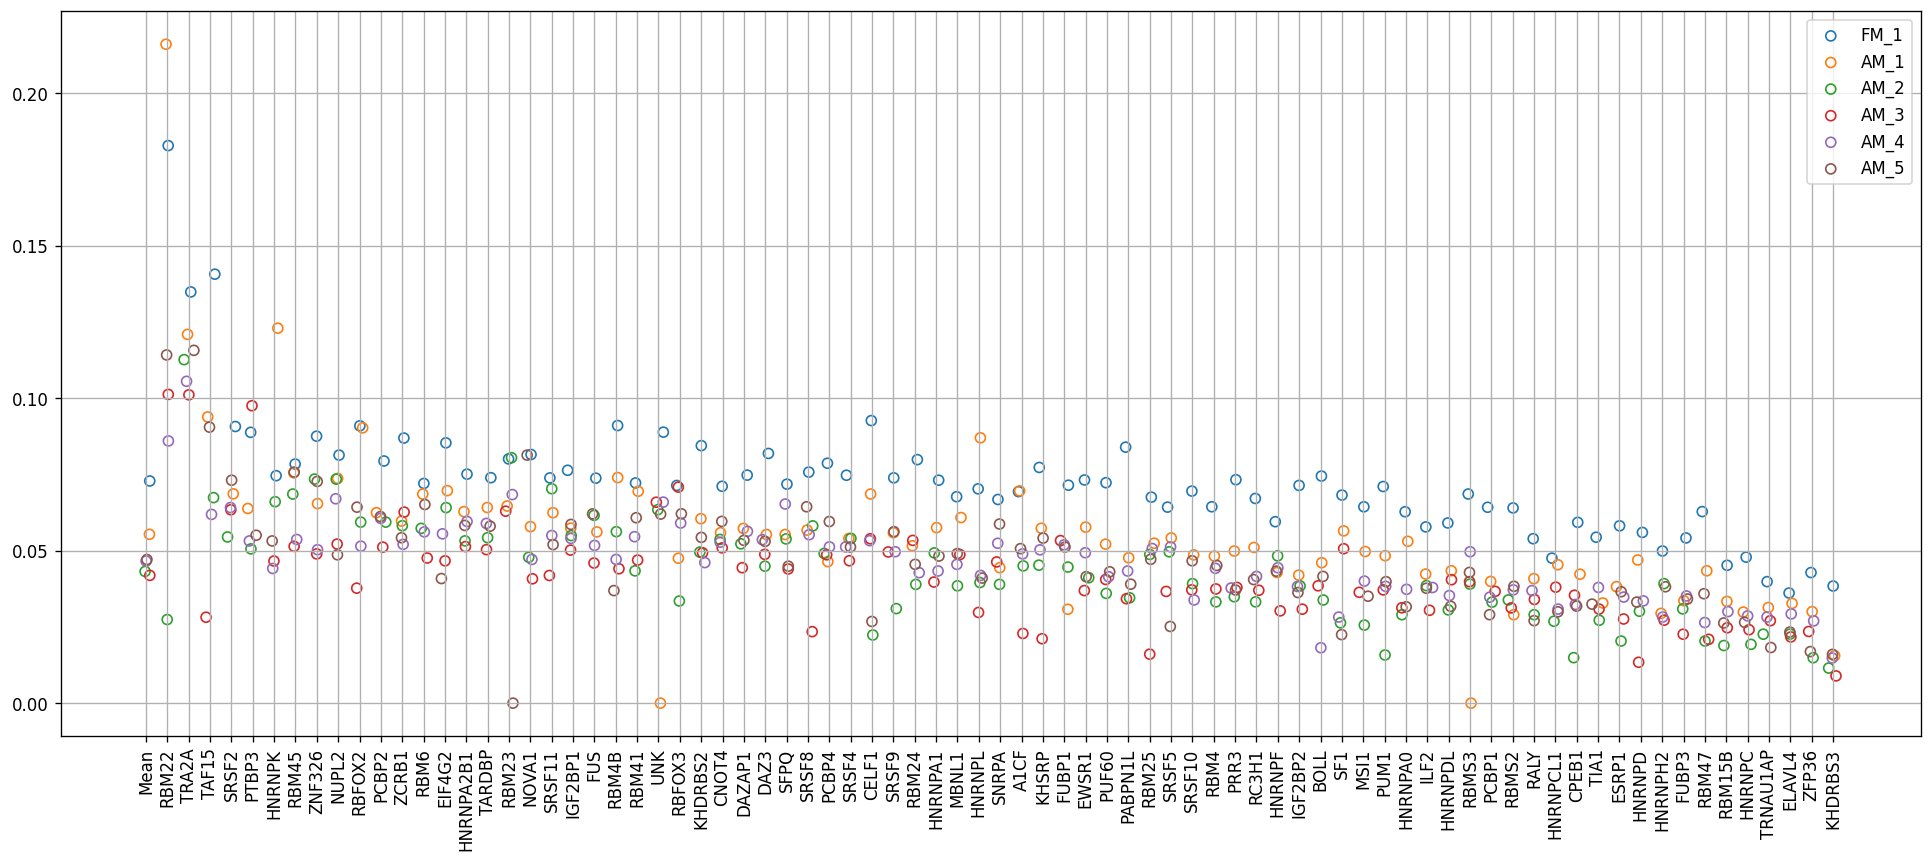

In [10]:
sensitivities = plot_sensitivity_by_motif(full_data, names)
sensitivities.to_csv("output-csvs/binarized/sensitivities.csv")

In [11]:
def correlation_comparison(fd1, fd2):
    return np.nanmean(
        [
            np.corrcoef(
                fd1[:, :, i].flatten(),
                fd2[:, :, i].flatten(),
            )[0, 1]
            for i in range(num_motifs)
        ]
    )

correlation_comparison = pd.DataFrame(
    [
        [correlation_comparison(full_data[n1.name], full_data[n2.name]) for n2 in models]
        for n1 in models
    ],
    columns=[x.name for x in models],
    index=[x.name for x in models],
)

/scratch/kavig/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/scratch/kavig/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [12]:
map_to_prefix = {x.name: x.name.split("_")[0].split("-")[0] for x in models}
categories = sorted(set(map_to_prefix.values()))
prefix_to_vals = {
    category: [v.name for v in models if map_to_prefix[v.name] == category]
    for category in categories
}

In [13]:
df = correlation_comparison.loc[prefix_to_vals["AM"], prefix_to_vals["AM"]]

In [14]:
def off_diagonals(df):
    return [df[c][r] for c in df for r in df.index if c != r]

In [15]:
correlation_comparison_by_category = pd.DataFrame(
    [
        [
            np.array(
                off_diagonals(
                    correlation_comparison.loc[prefix_to_vals[c1], prefix_to_vals[c2]]
                )
            ).mean()
            for c1 in categories
        ]
        for c2 in categories
    ],
    index=categories,
    columns=categories,
)

<ipython-input-15-5c6677cbe973>:4: RuntimeWarning: Mean of empty slice.
  np.array(
/scratch/kavig/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
correlation_comparison.to_csv(
    "output-csvs/binarized/downstream-effect-correlations.csv"
)

In [17]:
correlation_comparison_by_category.round(3)

,AM,FM
AM,0.672,0.749
FM,0.749,NaN


In [18]:
# path = "/scratch/kavig/img/binarized_models_rna_maps/"
# ! rm -r $path
# ! mkdir -p $path

In [19]:
def plot(motif_idx):
    d = np.concatenate(
        [full_data[m.name][:, :, [motif_idx]] for m in models], axis=2
    )
    plotter = EffectPlotter(
        d,
        [x.name for x in models],
        width_each=10,
        height_each=10,
        limit_mode=lambda x: np.percentile(x, 99.5),
    )
    plotter.plot_for_indices(
        list(range(len(models))),
        name=names[motif_idx],
    )

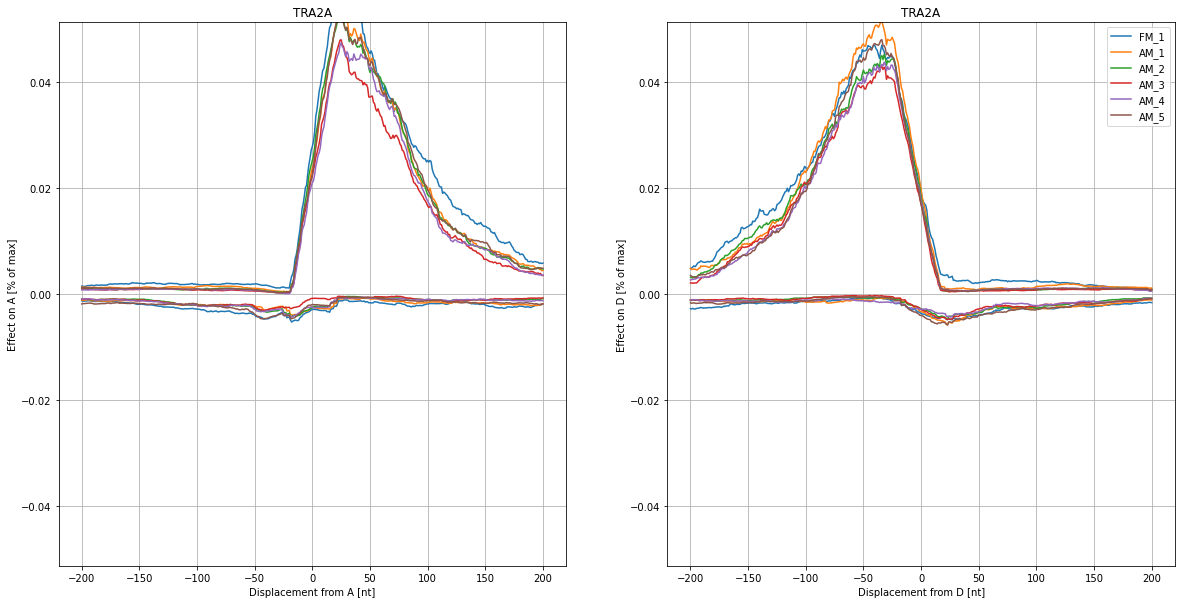

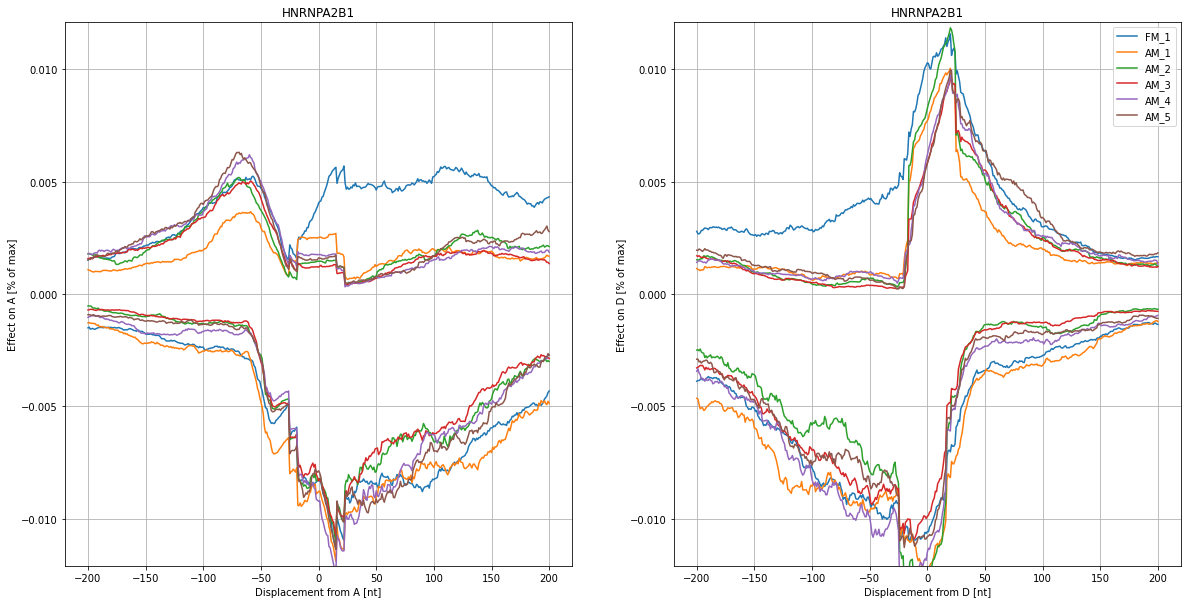

In [20]:
plot(names.index("TRA2A"))
plot(names.index("HNRNPA2B1"))